In [38]:
import msprime
from IPython.display import SVG
import dendropy
from dendropy.calculate.treecompare import symmetric_difference
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
#Simulate
L=1e8 
N=10000

#Neut
ts_neut = msprime.sim_ancestry(1000, recombination_rate=1e-8, sequence_length=L, ploidy=1, population_size=N)
mts_neut = msprime.sim_mutations(ts_neut, rate=1e-8)
print("Done with neuts")

#Hard sweep
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # beneficial mutation location: middle of chrom
    start_frequency=1.0 / (2 * N), # starting frequency of the sweeping mutation
    end_frequency=0.99, # final frequency of the mutation (incomplete sweep)
    s=0.25, # selection coefficient of the beneficial mutation
    dt=1e-6, # nevermind this!
)

ts_sweep = msprime.sim_ancestry(
    1000,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=N,
    recombination_rate=1e-8,
    sequence_length=L,
    ploidy=1,
)

mts_sweep = msprime.sim_mutations(ts_sweep, rate=1e-8)
print("Done with sweeps")

Done with neuts
Done with sweeps


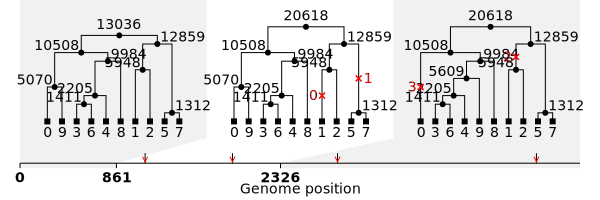

In [10]:
SVG(mts_neut.simplify(range(10)).draw_svg(time_scale="rank", x_lim=(0, 5000)))


In [16]:
#Treeseq to Nexus/Newick Conversion
neut_nex = mts_neut.simplify(range(10)).as_nexus(precision=3, include_alignments=False)
sweep_nex = mts_sweep.simplify(range(10)).as_nexus(precision=3, include_alignments=False)
with open("neut_simple.nex", "w") as ns:
    ns.writelines(neut_nex)

with open("sweep_simple.nex", "w") as ss:
    ss.writelines(sweep_nex)

In [ ]:
#Read in trees to Dendropy
#TODO Scale with yield_from_files
taxa = dendropy.TaxonNamespace()

neut_dendro = dendropy.TreeList.get(path="neut_simple.nex", schema="nexus", taxon_namespace=taxa)
sweep_dendro = dendropy.TreeList.get(path="sweep_simple.nex", schema="nexus", taxon_namespace=taxa)

In [ ]:
#Iterate through treelist, calc pairwise RFs
neut_rfs = []
for t_idx in range(len(neut_dendro)-1):
    neut_rfs.append(symmetric_difference(neut_dendro[t_idx], neut_dendro[t_idx+1]))

#Iterate through treelist, calc pairwise RFs
sweep_rfs = []
for t_idx in range(len(sweep_dendro)-1):
    sweep_rfs.append(symmetric_difference(sweep_dendro[t_idx], sweep_dendro[t_idx+1]))

In [26]:
#RF Dist Stats
neut_arr = np.array(neut_rfs)
sweep_arr = np.array(sweep_rfs)

print("Neutral")
print(pd.DataFrame(neut_arr).describe())

print("\nSweep")
print(pd.DataFrame(sweep_arr).describe())

Neutral
                  0
count  44972.000000
mean       2.189496
std        2.700257
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       16.000000

Sweep
                  0
count  27910.000000
mean       1.269151
std        1.835940
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max       12.000000


<AxesSubplot:title={'center':'Sweep RF Dist. vs Location'}>

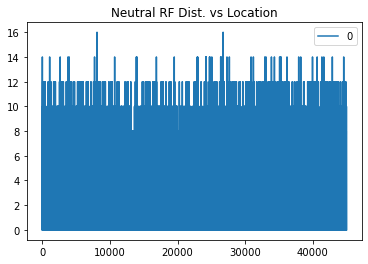

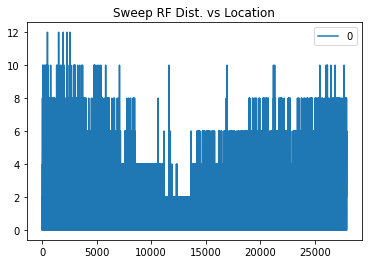

In [57]:
#Plot location-based RF
pd.DataFrame(neut_arr).plot(kind="line", title="Neutral RF Dist. vs Location")
pd.DataFrame(sweep_arr).plot(kind="line", title="Sweep RF Dist. vs Location")


In [ ]:
#Graph Nearest Neighbor(?)
def gnn(tree, k=3):
    """
    Graph Nearest Neighbor
    Pseudocode:
    - For range(1,k):
        - For each terminal node (t_n):
            - For each parent node (p_n) coalescent moves 1 to k: 
                - Get all descendants of p_n in dictionary    
    """
    raise NotImplementedError